In [2]:
import matplotlib as mlp
import matplotlib.pyplot as plt

In [3]:
results = {
    'SVM': [0.7747663551401869, 0.7747663551401869, 0.7747663551401869, 0.7747663551401869, 0.7747663551401869],
    'Decision Tree': [0.7850467289719626, 0.7850467289719626, 0.7850467289719626, 0.7845794392523364, 0.7850467289719626],
    'Random Forest': [0.8121495327102803, 0.8079439252336449, 0.8093457943925234, 0.8051401869158878, 0.8098130841121496],
    'XGBoost': [0.8168224299065421, 0.8168224299065421, 0.8168224299065421, 0.8168224299065421, 0.8168224299065421],
    'MLP': [0.803271, 0.792991, 0.796262, 0.797664, 0.797664]
}

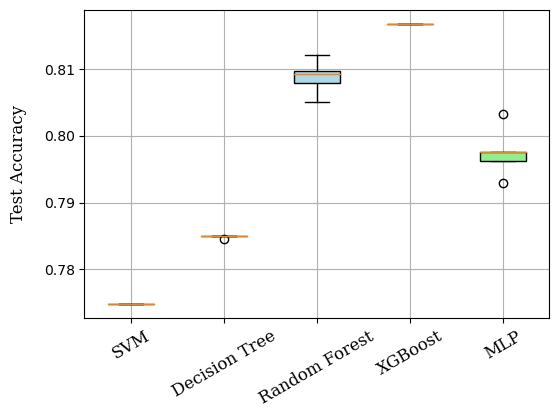

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(6,4))

bplot = axs.boxplot(results.values(), labels=['SVM', 'Decision\nTree', 'Random\nForest', 'XGBoost', 'MLP'], patch_artist=True)
colors = colors = ['pink', 'purple', 'lightblue', 'orange', 'lightgreen']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
fontdict = {'family':'serif', 'color':'black', 'weight':'normal', 'size':12}
axs.set_ylabel('Test Accuracy', fontdict=fontdict, labelpad=12)
axs.set_xticklabels(results.keys(), rotation=30, fontdict=fontdict)
axs.grid()
plt.show()